# Imports and Data Cleaning

In [1]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ast import literal_eval
from operator import itemgetter
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

conn = sqlite3.connect('../../Data/Experiment_4/exp4_Data.db')
dat = pd.read_sql('SELECT * FROM subjects WHERE complete=1', con=conn)
# forgot to remove non-prolific test runs, so I'll remove rows where prolific_id is a random float
dat = dat[[pp.isalnum() for pp in dat.prolific_id.values]]
# Setting some variables about the specifics of the stimulus
dat['agent'] = 'inanimate'
dat['patient'] = 'inanimate'
dat.loc[(dat.stim1 == 'anim_v1.mp4') & (dat.stim2 == 'y_p_v2.mp4'), 'agent'] = 'animate'
dat.loc[(dat.stim1 == 'anim_v1.mp4') & (dat.stim2 == 'p_y_v2.mp4'), 'patient'] = 'animate'
dat.loc[(dat.agent=='animate') & (dat.patient == 'inanimate'), 'condition'] = 'anim agent/phys patient'
dat.loc[(dat.agent=='inanimate') & (dat.patient == 'inanimate'), 'condition'] = 'phys agent/phys patient'
dat.loc[(dat.agent=='inanimate') & (dat.patient == 'animate'), 'condition'] = 'phys agent/anim patient'
ordering = ['phys agent/phys patient', 'anim agent/phys patient','phys agent/anim patient']
# reformatting string data to int
for prompt in ['Q1', 'Q2','Q3', 'Q4']:
    if prompt in ['Q3', 'Q4']:
        dat[prompt] = dat.loc[dat.cohort == 'combine_cohort'][prompt].apply(lambda x: literal_eval(x)[-1])
    else:
        dat[prompt] = dat[prompt].apply(lambda x: literal_eval(x)[-1])


# Do counterfactuals for agent impact causal attributions to the same degree as counterfactuals for objects?

# Experiment Conditions and Stimuli

| Condition                                                                          | Prime                                               | Test                                           |
|------------------------------------------------------------------------------------|-----------------------------------------------------|------------------------------------------------|
| <font color="#F0F000">Object</font> <br> hits <font color= "#FF00FF">Object</font> | ![SegmentLocal](Figures/gifs/phys_v1.gif "segment") | ![SegmentLocal](Figures/gifs/p_y_v2.gif "segment") |
| <font color="#FF00FF"> Agent</font><br/> hits <font color="#F0F000">Object</font>  | ![SegmentLocal](Figures/gifs/anim_v1.gif "segment") | ![SegmentLocal](Figures/gifs/y_p_v2.gif "segment") |
| <font color="#F0F000">Object</font><br/>hits<font color="#FF00FF"> Agent</font>   | ![SegmentLocal](Figures/gifs/anim_v1.gif "segment") | ![SegmentLocal](Figures/gifs/p_y_v2.gif "segment") |

## Prompts
### Q1:  The [AGENT] ball cause the tower to fall
### Q2:  The [PATIENT] ball caused the tower to fall
### Q3: If [AGENT] had not been there, the tower would have remained standing.
### Q4: If [PATIENT] had not been there, the tower would have remained standing.


# Causal Ratings per Condition
## Hypotheses
### Condition: <font color="#F0F000">Object</font> hits <font color="#FF00FF">Object</font>
Since the outcome is viewed as over-determined in this case, there is no counterfactual dependence for either ball. We expect the patient to then be more causal than the patient according to process accounts.
* Q1: <font color="#F0F000">Agent LOWER causal rating</font>
* Q2: <font color="#FF00FF">Patient HIGHER causal rating </font>

### Condition: <font color="#FF00FF">Agent</font> hits <font color="#F0F000">Object</font>
There exists a counterfactual in which the agent could have prevented the outcome, thereby changing it.
* Q1: <font color="#FF00FF">Agent HIGHER causal</font>

There exists a counterfactual trajectory for the object, but given the agent's goal, it may not change the outcome.
* Q2: <font color="#F0F000">Object LOWER causal</font>

### Condition: <font color="#F0F000">Object</font> hits <font color="#FF00FF">Agent</font>
There exists a counterfactual for the object in which the outcome is changed (the agent doesn't hit the tower by itself).
* Q1: <font color="#F0F000">Object HIGH causal</font>

There exists a counterfactual for the agent in which the outcome is changed (the agent prevents outcome)
* Q2:  <font color="#FF00FF">Agent HIGH causal </font>


Note that we keep terms agent & patient in the sense of the collision and refer to balls as animate or inanimate.


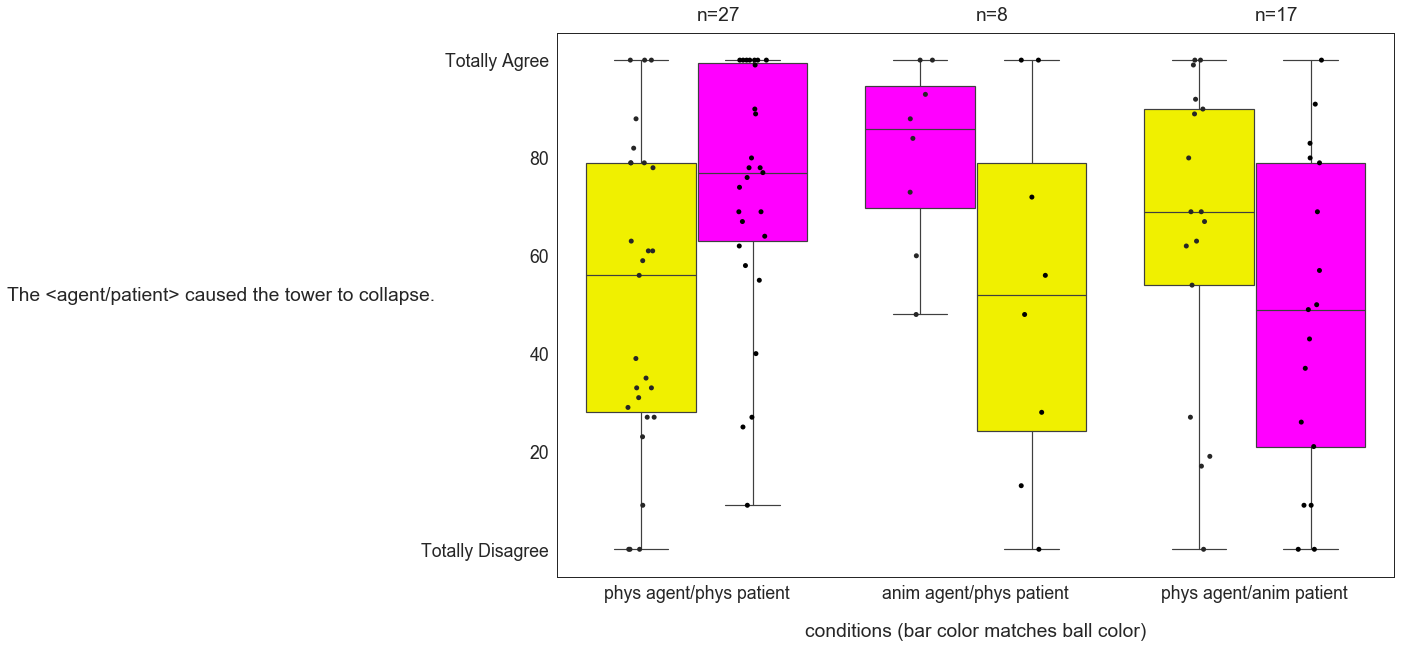

In [2]:
sns.set_context('paper', font_scale=2)
#sns.set_context('talk', font_scale=2)
print('Note that we keep terms agent & patient in the sense of the collision and refer to balls as animate or inanimate.')
fig, ax = plt.subplots(figsize=(15,10))
xx = dat.loc[dat.cohort == 'combine_cohort'].melt(id_vars=['agent', 'patient', 'condition'], value_vars=['Q1', 'Q2'], var_name='ball', value_name='causal_rating')
xx['ball'] = xx.ball.str.replace('Q1', 'agent_cause')
xx['ball'] = xx.ball.str.replace('Q2', 'patient_cause')
g = sns.boxplot(x='condition', y='causal_rating', hue='ball', data=xx, ax=ax, order=ordering)
cc = ["#F0F000","#FF00FF", "#FF00FF","#F0F000","#F0F000", "#FF00FF"]
for i in range(6):
    box = g.artists[i]
    box.set_facecolor(cc[i])
g = sns.stripplot(x='condition', y='causal_rating', hue='ball', data=xx, ax=ax, color='k', dodge=True, order=ordering)
g.legend_.remove()
#ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
#g.legend = False
ax.xaxis.labelpad = 20
ax.text(0, 108, "n="+str(len(dat.loc[(dat.condition==ordering[0]) & (dat.cohort == 'combine_cohort')])))
ax.text(1, 108, "n="+str(len(dat.loc[(dat.condition==ordering[1])  & (dat.cohort == 'combine_cohort')])))
ax.text(2, 108, "n="+str(len(dat.loc[(dat.condition==ordering[2])  & (dat.cohort == 'combine_cohort')]))
)
ax.set_ylabel("The <agent/patient> caused the tower to collapse.", rotation=0, labelpad=200)
ax.set_xlabel('conditions (bar color matches ball color)')
ax.set_yticklabels(['0', 'Totally Disagree', '20', '40', '60', '80', 'Totally Agree']);
#ax.set_xticklabels(['<font color="#FF00FF">Object</font> hits Object', 'hey', 'hey']);

#fig.savefig('Figures/Exp2b_cause.png')


# Counterfactual Ratings per Condition

## Hypotheses
### Condition: Inanimate Agent/ Inanimate Patient
_Counterfactual Ratings_
* Q3: Agent - LOW ratings, did not change outcome
* Q4: Patient - LOW ratings, did not change outcome

### Condition: Animate Agent/ Inanimate Patient
_Counterfactual Ratings_
* Q3: Agent - LOW ratings, did not change outcome, (overdetermined)
* Q4: Patient - LOW ratings, did not change outcome (agent equifinality)

### Condition: Inanimate Agent/ Animate Patient
_Counterfactual Ratings_
* Q3: Agent - HIGH ratings, did change outcome
* Q4: Patient - LOW ratings, (linear trajectory of inanimate agent)


Note that we keep terms agent & patient in the sense of the collision and refer to balls as animate or inanimate.


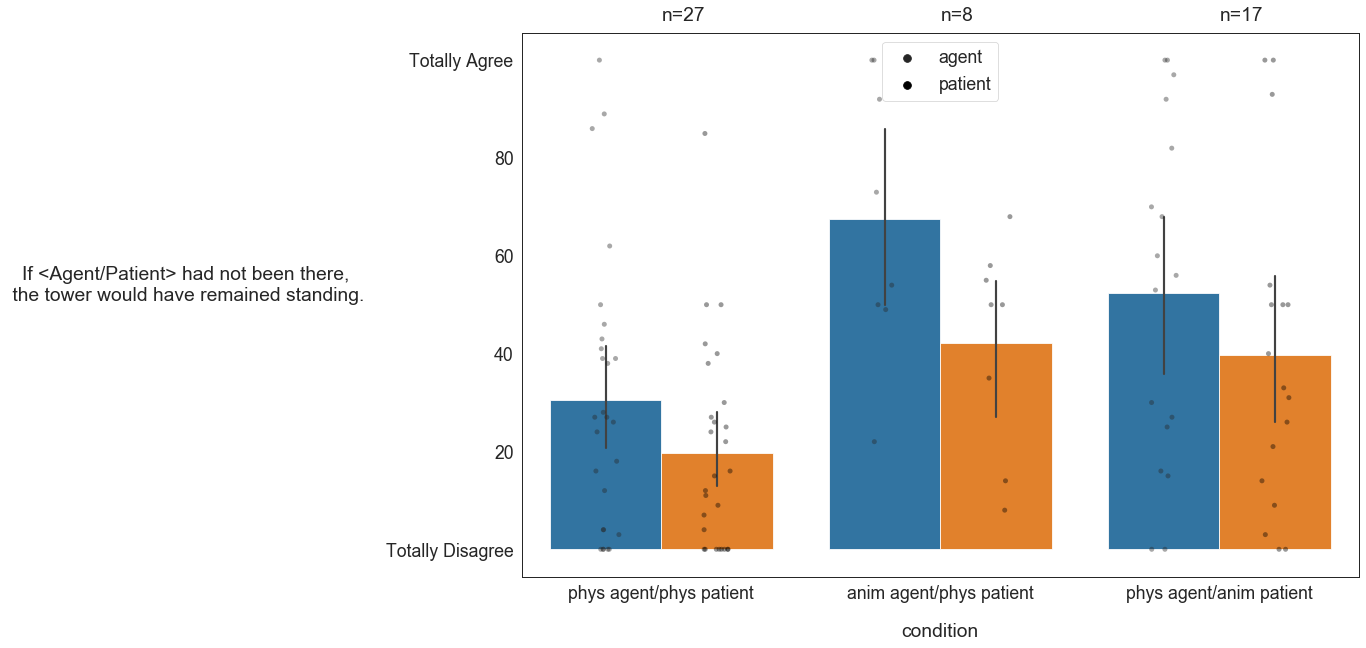

In [7]:
sns.set_context('paper', font_scale=2)
print('Note that we keep terms agent & patient in the sense of the collision and refer to balls as animate or inanimate.')

fig, ax = plt.subplots(figsize=(15,10))
xx = dat.loc[dat.cohort == 'combine_cohort'].melt(id_vars=['agent', 'patient', 'condition'], value_vars=['Q3', 'Q4'], var_name='ball', value_name='cf_rating')
xx['ball'] = xx.ball.str.replace('Q3', 'agent')
xx['ball'] = xx.ball.str.replace('Q4', 'patient')
g = sns.barplot(x='condition', y='cf_rating', hue='ball', data=xx, ax=ax, order=ordering)

g = sns.stripplot(x='condition', y='cf_rating', hue='ball', data=xx, ax=ax, color='k', alpha=.4, dodge=True, order=ordering)
#g = sns.pointplot(x='condition', y='cf_rating', hue='ball', data=xx, ax=ax, color='k', join=False, dodge=.4, capsize=.3, errwidth=.8, order=ordering, ci=68)


ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
ax.xaxis.labelpad = 20
ax.text(0, 108, "n="+str(len(dat.loc[(dat.condition==ordering[0]) & (dat.cohort == 'combine_cohort')])))
ax.text(1, 108, "n="+str(len(dat.loc[(dat.condition==ordering[1])  & (dat.cohort == 'combine_cohort')])))
ax.text(2, 108, "n="+str(len(dat.loc[(dat.condition==ordering[2])  & (dat.cohort == 'combine_cohort')]))
)

ax.set_ylabel("If <Agent/Patient> had not been there,\n the tower would have remained standing.", rotation=0, labelpad=200)
ax.set_yticklabels(['0', 'Totally Disagree', '20', '40', '60', '80', 'Totally Agree']);
plt.savefig('Figures/pilot_cf.png', bbox_inches='tight')

Note that we keep terms agent & patient in the sense of the collision and refer to balls as animate or inanimate.


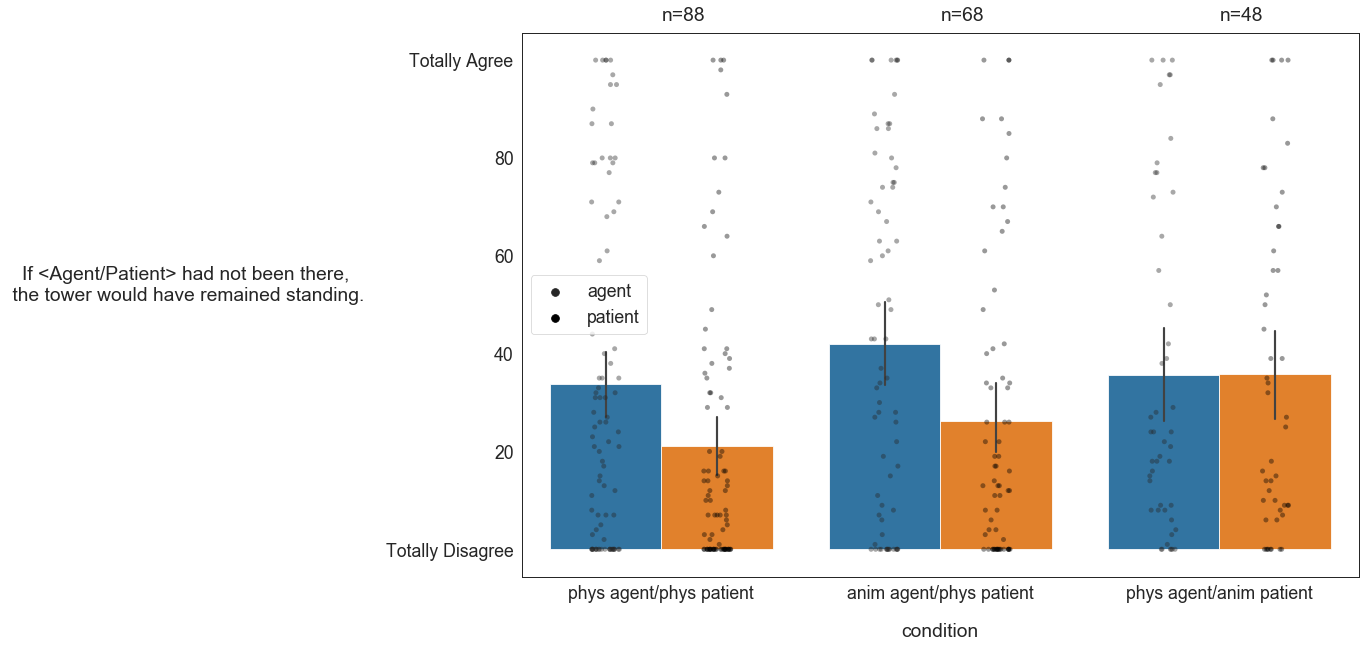

In [5]:
sns.set_context('paper', font_scale=2)
print('Note that we keep terms agent & patient in the sense of the collision and refer to balls as animate or inanimate.')

fig, ax = plt.subplots(figsize=(15,10))
xx = dat.loc[dat.cohort == 'CF_cohort'].melt(id_vars=['agent', 'patient', 'condition'], value_vars=['Q1', 'Q2'], var_name='ball', value_name='cf_rating')
xx['ball'] = xx.ball.str.replace('Q1', 'agent')
xx['ball'] = xx.ball.str.replace('Q2', 'patient')
#g = sns.violinplot(x='condition', y='cf_rating', hue='ball', data=xx, ax=ax, order=ordering, inner=None, cut=0)
g = sns.barplot(x='condition', y='cf_rating', hue='ball', data=xx, ax=ax, order=ordering)

g = sns.stripplot(x='condition', y='cf_rating', hue='ball', data=xx, ax=ax, color='k', alpha=.4, dodge=True, order=ordering)
#g = sns.pointplot(x='condition', y='cf_rating', hue='ball', data=xx, ax=ax, color='k', join=False, dodge=.4, capsize=.3, errwidth=.8, order=ordering, ci=68)


ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
ax.xaxis.labelpad = 20
ax.text(0, 108, "n="+str(len(dat.loc[(dat.condition==ordering[0]) & (dat.cohort == 'CF_cohort')])))
ax.text(1, 108, "n="+str(len(dat.loc[(dat.condition==ordering[1])  & (dat.cohort == 'CF_cohort')])))
ax.text(2, 108, "n="+str(len(dat.loc[(dat.condition==ordering[2])  & (dat.cohort == 'CF_cohort')]))
)

ax.set_ylabel("If <Agent/Patient> had not been there,\n the tower would have remained standing.", rotation=0, labelpad=200)
ax.set_yticklabels(['0', 'Totally Disagree', '20', '40', '60', '80', 'Totally Agree']);
plt.savefig('Figures/s2_cf.png', bbox_inches='tight')

# Causal x Counterfactual Ratings per Condition

In [ ]:
# Combining two long DFs
xx = dat.melt(id_vars=['agent', 'patient', 'condition'], value_vars=['Q1', 'Q2',], var_name='ball', value_name='cause_rating')
xx['ball'] = xx.ball.str.replace('Q1', 'agent')
xx['ball'] = xx.ball.str.replace('Q2', 'patient')
yy = dat.melt(id_vars=['agent', 'patient', 'condition'], value_vars=['Q3', 'Q4',], var_name='ball', value_name='cf_rating')
yy['ball'] = yy.ball.str.replace('Q3', 'agent')
yy['ball'] = yy.ball.str.replace('Q4', 'patient')
xx['counterfactual_dependence'] = yy.cf_rating

g = sns.lmplot(x='counterfactual_dependence', y='cause_rating', hue='ball', col='condition', data=xx)
[a.set_xlabel("If <Agent/Patient> had not been there,\n the tower would have remained standing.", fontsize=14)for a in g.axes[0,:]];
#[a.title = tt for a, tt in zip(g.axes[0,:], ['Object hits object', 'Agent hits object', 'Object hits agent'])];

#g.fig.savefig('Figures/cause_cf_pilot.png')

#  <font color="#F0F000">Object</font> hits <font color="#FF00FF">Object</font>

In [ ]:
c_dat = dat.loc[(dat.agent =='inanimate') & (dat.patient == 'inanimate')]

In [ ]:
sns.set_context('paper', font_scale=2)
fig, ax = plt.subplots(figsize=(15,10))
xx = c_dat.melt(id_vars=['agent', 'patient', 'condition'], value_vars=['Q3', 'Q4'], var_name='ball', value_name='cf_rating')
xx['ball'] = xx.ball.str.replace('Q3', 'agent')
xx['ball'] = xx.ball.str.replace('Q4', 'patient')
g = sns.boxplot(x='ball', y='cf_rating', data=xx, ax=ax, order=ordering)
g = sns.stripplot(x='ball', y='cf_rating', data=xx, ax=ax, color='k', dodge=True, order=ordering)

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
ax.xaxis.labelpad = 20
ax.text(0, 108, "n="+str(len(dat.loc[dat.condition==ordering[0]])))
#ax.text(1, 108, "n="+str(len(dat.loc[dat.condition==ordering[1]])))
#a#x.text(2, 108, "n="+str(len(dat.loc[dat.condition==ordering[2]]))

ax.set_ylabel("If <Ball> had not been there,\n the tower would have remained standing.", rotation=0, labelpad=200)
ax.set_yticklabels(['0', 'Totally Disagree', '20', '40', '60', '80', 'Totally Agree']);
#plt.savefig('Figures/pilot_cf.png', bbox_inches='tight')